In [1]:
from simulations.elastic_collisions import Body, HiddenVariables, Variables, ElasticCollisionSimulation
import torch
from torch import Tensor
from torch.distributions import Distribution
from typing import Union, Callable

### The n-body collision problem

##### Visualise n body collision scenes for different bodies

#### Scenario 1 - Assumptions: 
- No force field (i.e. no air drag, attraction forces between bodies etc.)
- bodies are points of mass (a 'radius' value sets a range in which two close points are assumed to have collided)
- collisions are elastic (no loss of energy)
- the 'radius' values are the same and constant for each body
- the masses are the same and constant for each body 
- collisions with borders are also elastic
- the initial positions are fixed 

**Hidden variables:** initial velocity vectors

In [2]:

total_time = 10.0 
dt = 0.1
space_size = 10.0
max_radius = space_size // 10.0
acceleration_coefficient_value = 0.0
constant_mass_value = 1.0
constant_radius_value = max_radius
velocity_distribution = torch.distributions.Uniform(low=-5.0, high=5.0)
position_distribution = torch.distributions.Uniform(low=0.0, high=space_size)

num_bodies = 4
VARIABLES = Variables(
    masses = torch.full((num_bodies,), constant_mass_value),
    radii = torch.full((num_bodies,), constant_radius_value),
    starting_positions = None,
    initial_velocities= None,
    acceleration_coefficients = torch.full((num_bodies,), acceleration_coefficient_value),
    num_bodies = num_bodies,
    space_size = torch.tensor([space_size, space_size]),
)

initial_positions = ElasticCollisionSimulation.sample_initial_positions_without_overlap(VARIABLES, position_distribution)
VARIABLES.starting_positions = initial_positions
print(f"initial_positions: {initial_positions}")

initial_velocities = velocity_distribution.sample(sample_shape=torch.Size([num_bodies, 2]))
print(f"initial_velocities: {initial_velocities}")


simulation = ElasticCollisionSimulation( variables=VARIABLES, 
                                         enable_logging=False, 
                                         noise=False)

HIDDENVARIABLES = HiddenVariables(num_bodies=None, 
                                  masses=None,
                                  radii=None,
                                  acceleration_coefficients=None, 
                                  initial_velocities=initial_velocities,)

result = simulation.simulate(hidden_variables=HIDDENVARIABLES, \
                             total_time=total_time, \
                             dt=dt)

position_history = simulation.get_position_history()
velocity_history = simulation.get_velocity_history()

print(f"position_history: {position_history}")

# assume that position history is of length num_bodies 
assert len(position_history) == num_bodies
assert len(velocity_history) == num_bodies

# print position histories for body 1 
print(f"position_history for body 1: {position_history[0]}")
print(f"time history for body 1: {len(position_history[0])}")

# Transform the history so that each element represents a timestep
position_history_by_timestep = list(map(list, zip(*position_history)))
velocity_history_by_timestep = list(map(list, zip(*velocity_history)))

num_timesteps = len(position_history_by_timestep)

print(f"position_history_by_timestep: {position_history_by_timestep}")

# Assume that position history is of length num_timesteps
assert len(position_history_by_timestep) == num_timesteps
assert len(velocity_history_by_timestep) == num_timesteps

# Print position histories for timestep 1
print(f"position_history for timestep 1: {position_history_by_timestep[0]}")
print(f"velocity_history for timestep 1: {velocity_history_by_timestep[0]}")

print(f"position of body 1 at timestep 1: {position_history_by_timestep[0][0]}")
print(f"velocity of body 1 at timestep 1: {velocity_history_by_timestep[0][0]}")



initial_positions: tensor([[4.2957, 3.8568],
        [5.6274, 7.5405],
        [8.4577, 4.4954],
        [1.0136, 8.5711]])
initial_velocities: tensor([[-2.1297,  2.4240],
        [-0.8247,  3.5234],
        [ 1.5414,  0.6818],
        [ 4.8983,  4.2975]])
position_history: [[tensor([4.0827, 4.0992]), tensor([3.8697, 4.3416]), tensor([3.6567, 4.5841]), tensor([3.4438, 4.8265]), tensor([3.2308, 5.0689]), tensor([3.0178, 5.3113]), tensor([2.6948, 5.3723]), tensor([2.3728, 5.4350]), tensor([2.0509, 5.4978]), tensor([1.7289, 5.5605]), tensor([1.4069, 5.6232]), tensor([1.0850, 5.6860]), tensor([0.7630, 5.7487]), tensor([1.0850, 5.8114]), tensor([1.4069, 5.8742]), tensor([1.7289, 5.9369]), tensor([1.4353, 5.8202]), tensor([1.1435, 5.7039]), tensor([0.8517, 5.5877]), tensor([1.1435, 5.4715]), tensor([1.4353, 5.3553]), tensor([1.7272, 5.2390]), tensor([2.0190, 5.1228]), tensor([2.3108, 5.0066]), tensor([2.6026, 4.8904]), tensor([2.8945, 4.7741]), tensor([2.5030, 5.1391]), tensor([2.1134, 5.502

In [3]:
# added collision history 

collision_history_by_timestep = simulation.get_collision_history_per_timestep()

In [4]:
# loop though collision history by timestep and print out the collision history
for timestep, collisions in collision_history_by_timestep.items():
    print(f"timestep {timestep}:")
    for collision in collisions:

        # if there is key "boundary" then use that instead of body2 
        if "boundary" in collision:
            print(f"collision at time {collision['time']}: body {collision['body1']} and boundary {collision['boundary']}")
        else:
            print(f"collision at time {collision['time']}: body {collision['body1']} and body {collision['body2']}")

timestep 0:
timestep 1:
collision at time 0.1: body 3 and boundary 1
timestep 2:
timestep 3:
timestep 4:
collision at time 0.4: body 2 and boundary 0
timestep 5:
collision at time 0.5: body 1 and boundary 1
timestep 6:
collision at time 0.6000000000000001: body 0 and body 3
timestep 7:
timestep 8:
collision at time 0.8: body 1 and body 3
timestep 9:
timestep 10:
collision at time 1.0: body 2 and body 3
timestep 11:
timestep 12:
collision at time 1.2000000000000002: body 1 and body 3
collision at time 1.2000000000000002: body 2 and boundary 0
timestep 13:
collision at time 1.3: body 0 and boundary 0
timestep 14:
timestep 15:
collision at time 1.5: body 2 and body 3
timestep 16:
collision at time 1.6: body 0 and body 1
timestep 17:
collision at time 1.7000000000000002: body 1 and body 3
timestep 18:
timestep 19:
collision at time 1.9000000000000001: body 0 and boundary 0
timestep 20:
timestep 21:
timestep 22:
collision at time 2.2: body 2 and boundary 1
timestep 23:
collision at time 2.3

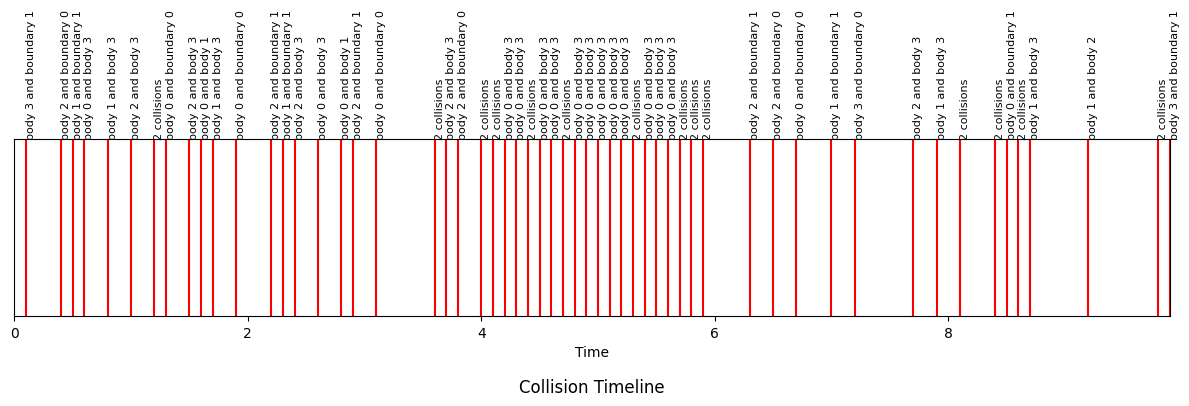

In [17]:
import matplotlib.pyplot as plt

# Get the total time span
total_time = max(collision['time'] for collisions in collision_history_by_timestep.values() for collision in collisions)

# Create a new figure
plt.figure(figsize=(12, 5))

# Loop through collision history by timestep
for timestep, collisions in collision_history_by_timestep.items():
    
    if len(collisions) == 1:
        collision = collisions[0]
        
        # Draw a vertical line at the time of the collision
        plt.vlines(collision['time'], 0, 1, colors='r')

        # Annotate the collision with smaller font size
        if "boundary" in collision:
            plt.text(collision['time'], 1, f"body {collision['body1']} and boundary {collision['boundary']}", rotation=90, verticalalignment='bottom', fontsize=8)
        else:
            plt.text(collision['time'], 1, f"body {collision['body1']} and body {collision['body2']}", rotation=90, verticalalignment='bottom', fontsize=8)
    elif len(collisions) > 1:
        collision = collisions[0]

        plt.vlines(collision['time'], 0, 1, colors='r')
        plt.text(collision['time'], 1, f"{len(collisions)} collisions", rotation=90, verticalalignment='bottom', fontsize=8)


# Set the limits and labels
plt.xlim(0, total_time)
plt.ylim(0, 1)
plt.xlabel('Time')
plt.yticks([])
ax = plt.gca()  # get current axes
ax.text(0.5, -0.4, 'Collision Timeline', ha='center', va='center', transform=ax.transAxes, fontsize=12)


# Show the plot
plt.tight_layout()
plt.savefig('collision_timeline.png')
plt.show()

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_timestep(ax, positions, velocities, space_size, max_radius):
    # Normalize the velocity vectors
    normalized_velocities = velocities / np.linalg.norm(velocities, axis=1, keepdims=True) * space_size

    # Set the limits of the plot
    ax.set_xlim([0, space_size])
    ax.set_ylim([0, space_size])

    # Set the aspect of the plot to be equal
    ax.set_aspect('equal')

    # Add a grid
    ax.grid(True)

    # Convert positions list to numpy array
    positions = np.array(positions)

    # Plot the positions of the bodies
    ax.scatter(positions[:, 0], positions[:, 1], color='b')

    # Add transparent circles at the location of each body
    for pos in positions:
        circle = patches.Circle((pos[0], pos[1]), radius=max_radius, alpha=0.5, edgecolor='none')
        ax.add_patch(circle)

    # Plot the normalized velocities as vectors and display the original velocity values
    for pos, vel, orig_vel in zip(positions, normalized_velocities, velocities):
        ax.quiver(pos[0], pos[1], vel[0], vel[1], color='r')
        ax.text(pos[0] + orig_vel[0]/2, pos[1] + orig_vel[1]/2, f'({orig_vel[0]:.2f}, {orig_vel[1]:.2f})', color='r', fontsize=40)

# Number of timesteps to plot
num_timesteps = 40

# Create a new figure with a grid of subplots
fig, axs = plt.subplots(8, 5, figsize=(80, 120))  # 5 rows, 8 columns

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Loop over the timesteps
for i in range(num_timesteps):
    # Get the positions and velocities for this timestep
    positions = position_history_by_timestep[i]
    velocities = velocity_history_by_timestep[i]

    # Plot this timestep
    plot_timestep(axs[i], positions, velocities, space_size, max_radius)
    axs[i].set_title(f'Timestep {i}', fontsize=46)


# Adjust the space between subplots to be minimal
#plt.subplots_adjust(wspace=0.01, hspace=0.1)
# Display the plot
plt.tight_layout()
plt.show()
    #

#### Training simple feed-forward predictor model